##  텍스트 요약(Text Summarization) : Attention 사용

In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### 데이터 가져오기

In [3]:
data = pd.read_csv("/content/drive/My Drive/NLP_LAB/Reviews.csv", nrows = 100000) 

# data = pd.read_csv("Reviews.csv", nrows = 100000) # 56만개중에서 10만개 만 읽어옴
len(data)

100000

In [4]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
data = data[['Text','Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [6]:
data.sample(10)

,Text,Summary
96262,"VERY GOOD SERVICE, FABULOUS PRODUCT, VERY FRES...",BLUE DIAMOND ALMONDS
98136,My baby loves this combination. It is relative...,My Baby Loves It
78948,My daughter gave me Bentley's green tea one Ch...,best green tea ever
64601,This stuff is amazing. I just got a rice cooke...,The best wild rice
85831,"Though the texture is hearty and thick, this s...",Too sweet for me too
41464,I don't have to say too much as these are made...,"Made in China, that's all you need to know."
37095,I have a hard time finding food my cat likes a...,My cat really likes this food!
17333,We have been baking these brownies for several...,Took Top Honors
42969,When I received my Newman's Dark Chocolate Bar...,"Tasty & Organic, but Hershey's Gets the Gold"
75766,This energy drink has a pretty tasty berry fla...,Good taste


###  텍스트 전처리

In [7]:
print(data['Text'].nunique())
print(data['Summary'].nunique())

88426
72348


In [8]:
data.drop_duplicates(subset=['Text'], inplace=True)
len(data)

88426

In [9]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [10]:
data.dropna(axis=0, inplace=True)
len(data)

88425

In [11]:
# 줄임말(축약어)
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [12]:
# 불용어
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
# 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'aren', 'not', 'here', 'themselves', 'our', 'an', 'himself', 'be', 'so', 'all', "haven't", "doesn't", 'and', 'with', 'most', 'was', 'between', 'few', 'into', "you'll", 'before', "wasn't", "couldn't", "shouldn't", 'them', 'up', 'ma', 'the', 'him', 've', 'were', "should've", 'who', 'you', 'me', 'for', 'above', 'their', 'off', 'it', 'didn', 'have', 'out', 'wasn', "you're", 'its', 'mightn', 'such', 'as', 'under', 'don', "aren't", 'he', 'having', "wouldn't", 'my', 'to', "isn't", 'are', 'she', 'own', 'herself', 'doing', 'by', 's', "you'd", 'his', "it's", "hasn't", 'shouldn', "mightn't", 'a', 'i', 'this', 'once', 'couldn', 'both', 'm', 'won', 'is', 'needn', 'yourselves', 'further', 'shan', 'if', 'her', 'again', 'nor', 'just', 'from', "she's", "mustn't", 'at', "won't", 'ain', "don't", 'now', 'd', 'but', 'hasn', 'there', 'yourself', 'am', 'when', 'only', 'being', 'then', 'can', 'some', 'any', 'through', 'does', 'down', 'ours', 'had', 'do', 'very', 'we', 't', 'whom', 'while', "that

In [14]:
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower()                     # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)   # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence)             # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence)         # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)   # m이 2개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [15]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))  # 불용어를 제거하지 않고 괄호로 닫힌 문자열을 제거한다

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [16]:
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [17]:
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [18]:
data['Text'] = clean_text
data['Summary'] = clean_summary

In [19]:
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text        0
Summary    70
dtype: int64


In [20]:
data.dropna(axis = 0, inplace = True)
len(data)

88355

Text min : 2
Text max : 1235
Text mean : 38.792428272310566
Summary min : 1
Summary max : 28
Summary mean : 4.010729443721352


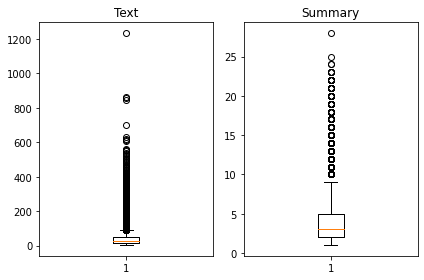

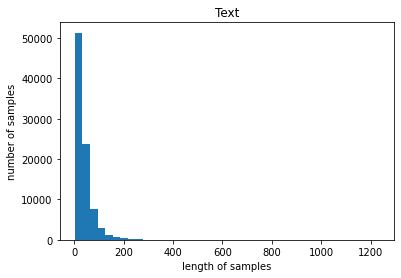

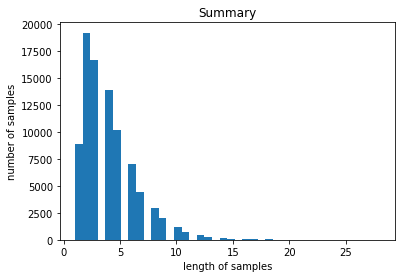

In [21]:
# 길이 분포 시각화 
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]


print('Text min : {}'.format(np.min(text_len)))
print('Text max : {}'.format(np.max(text_len)))
print('Text mean : {}'.format(np.mean(text_len)))
print('Summary min : {}'.format(np.min(summary_len)))
print('Summary max : {}'.format(np.max(summary_len)))
print('Summary mean : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

plt.show()

In [22]:
text_max_len = 50
summary_max_len = 8

In [23]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [24]:
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859


In [25]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [26]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]       # Text의 길이가 50이하인 행 추출
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)] # Summary의 길이가 8이하인 행 추출 
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 65818


In [27]:
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [28]:
data['Summary'] = data['Summary'].apply(lambda x : 'sostoken '+ x + ' eostoken')
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,sostoken good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,sostoken not as advertised eostoken
2,confection around centuries light pillowy citr...,sostoken delight says it all eostoken
3,looking secret ingredient robitussin believe f...,sostoken cough medicine eostoken
4,great taffy great price wide assortment yummy ...,sostoken great taffy eostoken


In [29]:
Text_data = list(data['Text'])
Summary_data = list(data['Summary'])

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Text_data, Summary_data, test_size=0.2, random_state=0, shuffle=True)

print('X_train :', len(X_train))
print('y_train :',len(y_train))
print('X_test :',len(X_test))
print('y_test :',len(y_test))

X_train : 52654
y_train : 52654
X_test : 13164
y_test : 13164


In [31]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(X_train)

In [32]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0                              # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                            # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                             # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 
for key, value in src_tokenizer.word_counts.items():  # word_counts :단어의 빈도
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('--X_train--')
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

--X_train--
단어 집합(vocabulary)의 크기 : 31940
등장 빈도가 6번 이하인 희귀 단어의 수: 23707
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8233
단어 집합에서 희귀 단어의 비율: 74.22354414527238
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.3949897589412323


In [33]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(X_train)


X_train = src_tokenizer.texts_to_sequences(X_train) 
X_test = src_tokenizer.texts_to_sequences(X_test)

In [34]:
print(X_train[:5])

[[4256, 611, 816, 4477, 528, 1540, 32, 45, 4, 79, 2281, 234, 19, 1157, 2923, 948, 1122, 996, 2, 153, 10, 43], [204, 15, 154, 51, 259, 60, 73, 24, 49, 17, 886, 259, 2, 29, 209, 14, 504, 2081, 420, 13, 86, 64, 22, 2464, 134, 14, 504, 86], [112, 1570, 2, 1771, 185, 39, 505, 112, 283], [296, 105, 496, 834, 69, 103, 334, 5082, 2294, 765, 7, 908, 585, 1489, 351, 5265, 100, 75, 1908, 137, 141, 585, 864, 5083, 89, 830, 564, 1772, 305, 254, 1541, 97, 247, 2, 1600, 2100, 92, 2645], [54, 1247, 806, 5, 497, 479, 46, 236, 1218, 381, 5, 3879, 3880, 172, 479, 46, 1247]]


In [35]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(y_train)

In [36]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index)   # 단어의 수
rare_cnt = 0                                # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                              # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                               # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
print('--y_train--')
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

--y_train--
단어 집합(vocabulary)의 크기 : 10498
등장 빈도가 5번 이하인 희귀 단어의 수: 8126
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2372
단어 집합에서 희귀 단어의 비율: 77.40522004191274
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.833194065065198


In [37]:
tar_vocab = 1000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(y_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
y_train = tar_tokenizer.texts_to_sequences(y_train) 
y_test = tar_tokenizer.texts_to_sequences(y_test) 

In [38]:
print(y_train[:5])
type(y_train)

[[1, 805, 2], [1, 7, 298, 138, 86, 2], [1, 25, 745, 2], [1, 488, 39, 22, 30, 12, 2], [1, 15, 16, 238, 84, 35, 12, 2]]


list

In [39]:
drop_train = [index for index, sentence in enumerate(y_train) if len(sentence) == 2]
drop_test = [index for index, sentence in enumerate(y_test) if len(sentence) == 2]

In [40]:
print('X_train :', len(X_train))
print('y_train :',len(y_train))
print('X_test :',len(X_test))
print('y_test :',len(y_test))

X_train : 52654
y_train : 52654
X_test : 13164
y_test : 13164


In [41]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

print('X_train :', len(X_train))
print('y_train :',len(y_train))
print('X_test :',len(X_test))
print('y_test :',len(y_test))
X_test.shape

X_train : 50512
y_train : 50512
X_test : 12609
y_test : 12609


(12609,)

### 토큰화와 패딩

In [42]:
X_train = pad_sequences(X_train, maxlen = text_max_len, padding='post')
X_test = pad_sequences(X_test, maxlen = text_max_len, padding='post')
y_train = pad_sequences(y_train, maxlen = summary_max_len, padding='post')
y_test = pad_sequences(y_test, maxlen = summary_max_len, padding='post')

###  Seq2eq 와 Attention 사용 모델 구현

In [43]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [44]:
embedding_dim = 64
hidden_size = 128

# 인코더
encoder_inputs = Input(shape=(text_max_len,))  # text_max_len :50

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.0)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.0)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.0)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [45]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.0)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [47]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

# Model()과 Sequential() 과의 차이 : Sequential은 Input layer를 사용하지 않음 ,선형 연결이므로 Connected to 가 표시도지 않음
# https://frhyme.github.io/machine-learning/a_model_in_keras/

# Connected to의  'xxx[0][0]' 설명
# https://stackoverflow.com/questions/53942291/what-does-the-00-of-the-layers-connected-to-in-keras-model-summary-mean

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 64)       512000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 128), (N 98816       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [48]:
# 깃허브에 공개된 attention.py 사용하기
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [49]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 64)       512000      input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 128), (N 98816       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [50]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [51]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

# 약 9분 소요(GPU)
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:] \
                  ,epochs=50, callbacks=[es], batch_size = 256, validation_data=([X_test, y_test[:,:-1]], \
                  y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/50
198/198 [==============================] - 11s 56ms/step - loss: 2.8381 - val_loss: 2.5371
Epoch 2/50
198/198 [==============================] - 10s 50ms/step - loss: 2.4965 - val_loss: 2.4375
Epoch 3/50
198/198 [==============================] - 10s 48ms/step - loss: 2.3894 - val_loss: 2.3461
Epoch 4/50
198/198 [==============================] - 10s 49ms/step - loss: 2.3021 - val_loss: 2.2674
Epoch 5/50
198/198 [==============================] - 10s 50ms/step - loss: 2.2329 - val_loss: 2.2090
Epoch 6/50
198/198 [==============================] - 10s 50ms/step - loss: 2.1651 - val_loss: 2.1725
Epoch 7/50
198/198 [==============================] - 10s 48ms/step - loss: 2.1075 - val_loss: 2.1074
Epoch 8/50
198/198 [==============================] - 10s 51ms/step - loss: 2.0619 - val_loss: 2.0775
Epoch 9/50
198/198 [==============================] - 10s 49ms/step - loss: 2.0244 - val_loss: 2.0495
Epoch 10/50
198/198 [==============================] - 10s 49ms/step - loss: 1.994

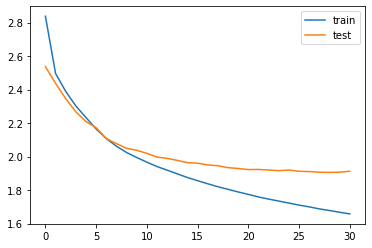

In [52]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

##  택스트 요약 예측함수 구현

In [53]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [54]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [55]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [56]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [57]:
# 예측함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [58]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [59]:
for i in range(500, 1000):
    print("원문 : ",seq2text(X_test[i]))
    print("실제 요약문 :",seq2summary(y_test[i]))
    print("예측 요약문 :",decode_sequence(X_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  dirty martini olive husband loves martini like people jars olives juice read company online actually cheaper order amazon husband fussy martini drinker loves amazing save buying lots jars olives never get used give try disappointed 
실제 요약문 : if you like 
예측 요약문 :  great product


원문 :  impressed tuna ok companies efforts ended giving cans away used meal usually like tuna oil thought flavor lacking think tuna canned juices much better wild planet caught wild tuna ounce cans 
실제 요약문 : did not like too much 
예측 요약문 :  not what expected


원문 :  coffee excellent delivered makes count lasts long enough two us month definitely keep coming 
실제 요약문 : good coffee 
예측 요약문 :  great coffee


원문 :  buying coffee least years love smooth taste hint hazelnut friends enjoy coming good cup coffee 
실제 요약문 : great coffee 
예측 요약문 :  great coffee


원문 :  tried coffee wonderful smooth rich full flavored bold would recommend anyone 
실제 요약문 : great coffee 
예측 요약문 :  best coffee


원문 :  never problem anyth